In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, gzip
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [3]:
DATASET = 'stochastic_block_model'
D_in = 8
D_out = 8

In [4]:
!python3 deepwalk.py --emb-dim 8 --input data/stochastic_block_model.edgelist.gz --output embs/stochastic_block_model_DeepWalk_8dims.txt.gz

Generating walks (CPU: 1): 100%|████████████████| 20/20 [00:00<00:00, 54.98it/s]
Training
Dumping the DeepWalk embeddings


In [5]:
!python3 dine.py --emb-dim 8 --input embs/stochastic_block_model_DeepWalk_8dims.txt.gz --output embs/stochastic_block_model_DeepWalk_8dims.Dine_8dims.txt.gz

Loading data from embs/stochastic_block_model_DeepWalk_8dims.txt.gz
Loaded data. #shape = (80, 8)
 #nodes = 80 
Building model 
After epoch 0, Rec. Loss = 0.80369, Size Loss = 0.01156, Orth. Loss = 0.02000, and Total = 0.83524
After epoch 500, Rec. Loss = 0.00466, Size Loss = 0.00001, Orth. Loss = 0.00789, and Total = 0.01256
After epoch 1000, Rec. Loss = 0.00527, Size Loss = 0.00001, Orth. Loss = 0.00595, and Total = 0.01123
After epoch 1500, Rec. Loss = 0.00533, Size Loss = 0.00001, Orth. Loss = 0.00143, and Total = 0.00677
After epoch 2000, Rec. Loss = 0.00520, Size Loss = 0.00000, Orth. Loss = 0.00141, and Total = 0.00662
Dumping the DINE embeddings
shape (80, 8)


In [6]:
import networkx as nx

graph = nx.read_weighted_edgelist(f'data/{DATASET}.edgelist.gz')
graph.remove_edges_from(nx.selfloop_edges(graph))
node_name = np.array(list(graph.nodes()))
node_dict = dict(zip(node_name, np.arange(len(node_name))))

In [7]:
import community as community_louvain

community_dict = community_louvain.best_partition(graph, resolution=1, random_state=11)
edge_communities = np.array(['-'.join(map(str, sorted([community_dict[i], community_dict[j]]))) for i,j in graph.edges()])

In [8]:
import utils

# emb_dict = utils.load_embs(f'embs/{DATASET}_DeepWalk_{D_out}dims.txt.gz')
emb_dict = utils.load_embs(f'embs/{DATASET}_DeepWalk_{D_in}dims.Dine_{D_out}dims.txt.gz')

emb_X = np.array([emb_dict[n] for n in node_name]) 

i_dims, i_masks, i_labels, i_scores, i_entropies = utils.edge_interpretability_parallel(graph, emb_X,  
                                                                                        edge_communities)

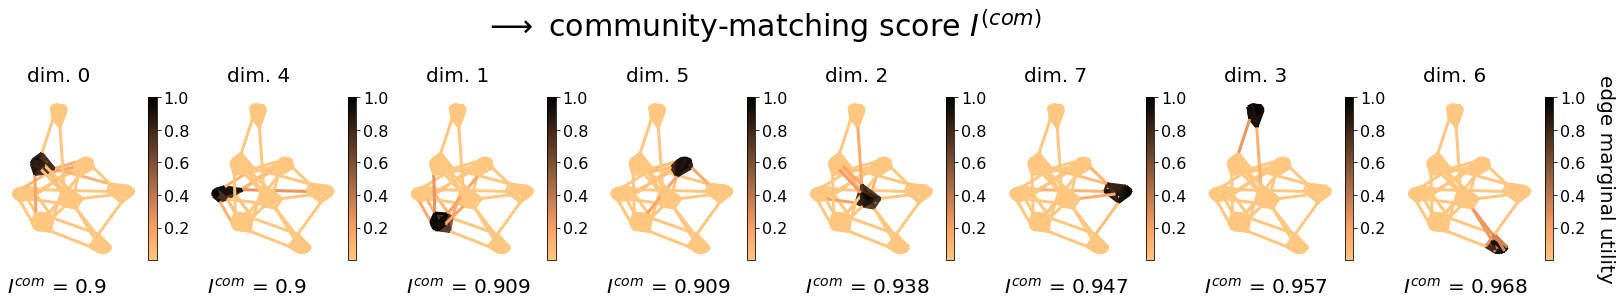

In [9]:
fig, ax = plt.subplots(1, D_out, figsize=(3.5*D_out,3))

ax = ax.ravel()

for axx in ax:
    axx.axis('off')

pos=nx.spring_layout(graph, seed=2)

THRESH = 1e-9

fig.suptitle(x=0.5, y=1.3, t=r'$\longrightarrow$ community-matching score $I^{(com)}$', fontsize=30)

for i,dim in enumerate(np.argsort(i_scores)):
       
    color = i_masks[dim]/i_masks[dim].max()
    vmin = min(color)
    vmax = max(color)
    cmap = plt.cm.copper_r
    
    nx.draw(graph, pos, edge_color=color, width=3, edge_cmap=cmap, node_size=0,
               with_labels=False, vmin=vmin, vmax=vmax, ax=ax[i])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
    
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax[i])
    cbar.ax.tick_params(labelsize=16)
    ax[i].text(x=0.15, y=1.1, s='dim. '+str(dim), transform=ax[i].transAxes, fontsize=20)
    
    ax[i].text(x=0., y=-0.2, s=r'$I^{com}$ = '+ str(round(i_scores[dim], 3)), transform=ax[i].transAxes, fontsize=20)
    if i==D_out-1:
        cbar.ax.set_ylabel('edge marginal utility', rotation=270, labelpad=30, fontsize=20)

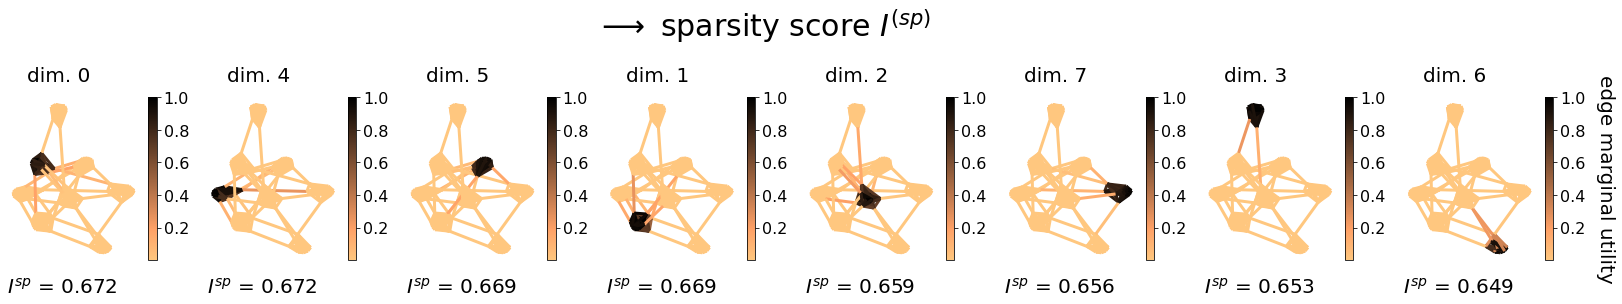

In [10]:
fig, ax = plt.subplots(1, D_out, figsize=(3.5*D_out,3))

ax = ax.ravel()

for axx in ax:
    axx.axis('off')

pos=nx.spring_layout(graph, seed=2)

THRESH = 1e-9

fig.suptitle(x=0.5, y=1.3, t=r'$\longrightarrow$ sparsity score $I^{(sp)}$', fontsize=30)

for i,dim in enumerate(np.argsort(i_entropies)[::-1]):
       
    color = i_masks[dim]/i_masks[dim].max()
    vmin = min(color)
    vmax = max(color)
    cmap = plt.cm.copper_r
    
    nx.draw(graph, pos, edge_color=color, width=3, edge_cmap=cmap, node_size=0,
               with_labels=False, vmin=vmin, vmax=vmax, ax=ax[i])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
    
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax[i])
    cbar.ax.tick_params(labelsize=16)
    ax[i].text(x=0.15, y=1.1, s='dim. '+str(dim), transform=ax[i].transAxes, fontsize=20)
    
    ax[i].text(x=0., y=-0.2, s=r'$I^{sp}$ = '+ str(round(i_entropies[dim], 3)), transform=ax[i].transAxes, fontsize=20)
    if i==D_out-1:
        cbar.ax.set_ylabel('edge marginal utility', rotation=270, labelpad=30, fontsize=20)